# GraphWaveNet with GAT: Local Training and Fine-tuning Example

## Overview
This notebook demonstrates:
- Local training methods
- Pre-trained model evaluation 
- Fine-tuning of pre-trained models

## Data Description

### River Network Structure
We'll be working with the USGS-01052500 watershed:
- **Main channel configuration**: 
 - 7 nodes
 - 8 edges
 - Gauge station located at the outlet
 - Connected to main stem structure

### Dataset Components
1. **River Network Information**
  - Built using Python HyRiver package 
  - Stream network topology and characteristics (NHDPlusV2 Dataset)

2. **Streamflow Data**
  - NWS-retrospective Dataset for reach-level flows (by comid)
  - CAMELS dataset observations at the outlet gauge

3. **Meteorological Data**
  - DaymetV4 weather information for each node
  - Creates dynamic node attributes

## Model Architecture

### Dynamic Graph Structure
- Network topology remains constant
- Node values update dynamically
- Meteorological and flow attributes change over time

### GAT-based GraphWaveNet
Key improvements over traditional GraphWaveNet:
- Handles dynamically changing node values
- Flexible to varying numbers of nodes
- Replaces traditional GCN with Graph Attention Network (GAT)

In [1]:
from engine import Engine
import torch
e = Engine(config_path="./config/test.yaml")
e # print the model structure

GraphWaveNet(
  (input): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
  (static_emb): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (tcn_a): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (tcn_b): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (gat): ModuleList(
    (0-3): 4 x GATConv(16, 16, heads=4)
  )
  (bn): Module

c:\Users\82105\GATWN\GATWN\dataset.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.data_dir, f"{self.gauge_id}.pt"))
c:\Users\82105\

When training is executed, the model results will be saved in the project path specified within test.yaml.

In [ ]:
e.train_full(ev=True) # train and evaluate the model locally to one specific catchment

c:\Users\82105\GATWN\GATWN\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weather = torch.tensor(self.weather, dtype=torch.float32)


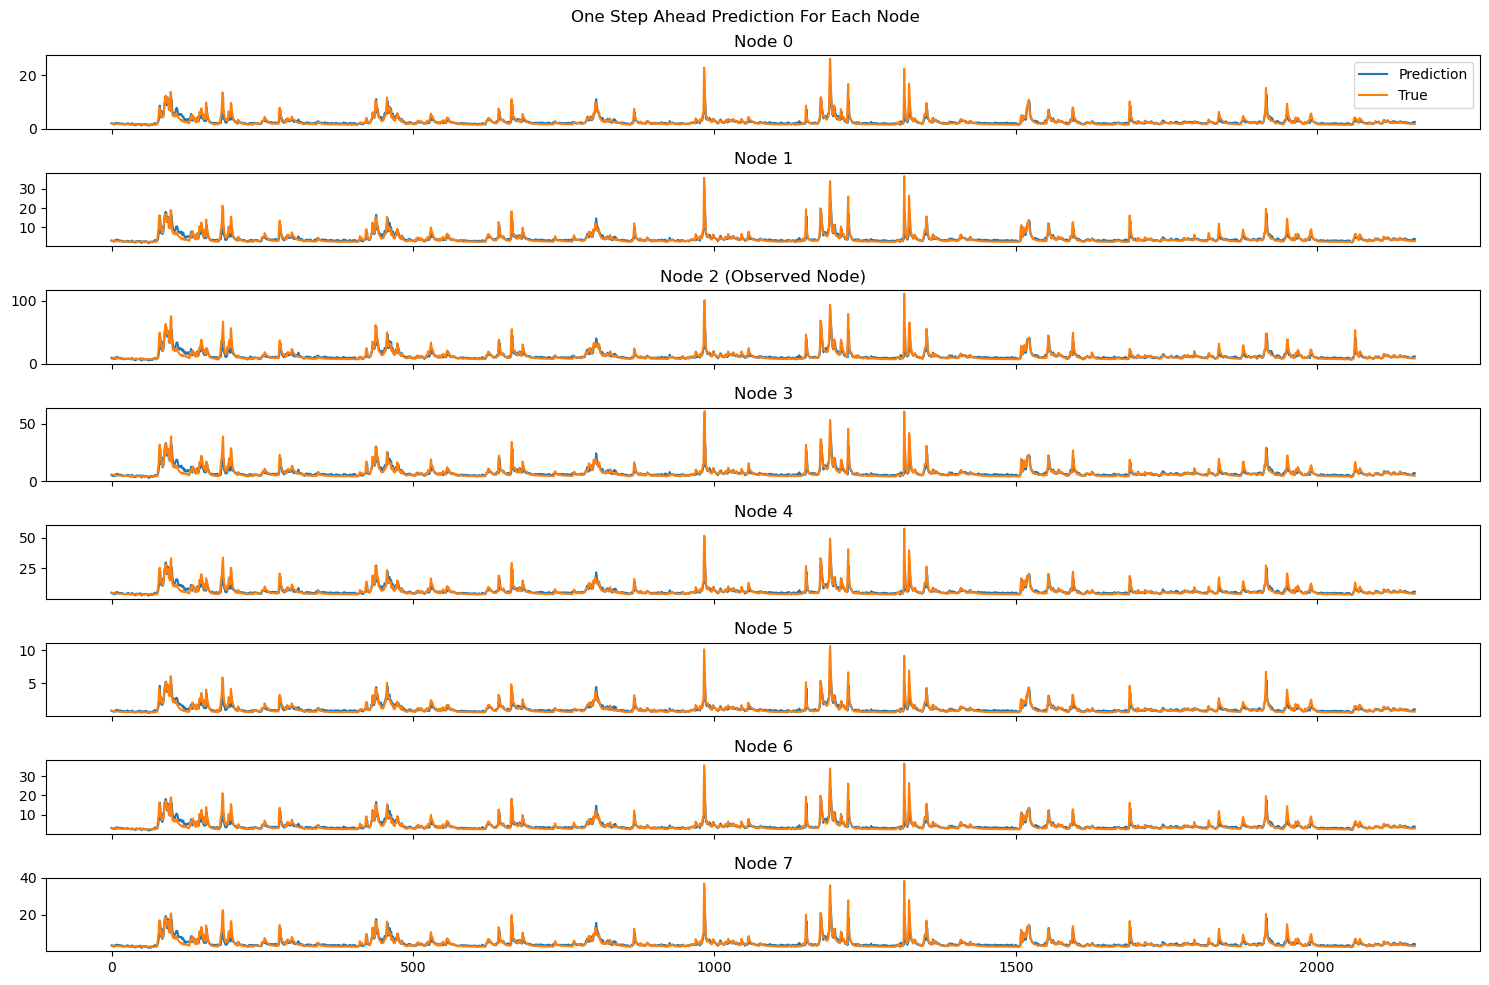

In [12]:
# 3번째 epoch 결과를 불러와 예측 결과를 확인해보겠습니다.
import torch
import matplotlib.pyplot as plt
from dataset import DynamicGraphDataset
import yaml
ds = DynamicGraphDataset(config=yaml.safe_load(open("./config/test.yaml")), gauge_id="01052500", ds_type="eval")

obs_idx = ds.outlet_idx # 2 is the outlet index of the catchment
num_nodes = ds.num_nodes
d = torch.load('runs/test/checkpoint/checkpoint_epoch_3.pt')
y_pred = d["results"]["01052500"]["y_pred"]
y_true = d["results"]["01052500"]["y_true"]
y_pred.shape, y_true.shape # (Time, Prediction Length, Number of nodes), (Time, Prediction Length, Number of nodes)

# We can plot one step ahead prediction for each node

fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(y_pred[:, 0,i], label="Prediction")
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("One Step Ahead Prediction For Each Node")
plt.tight_layout()

Furthermore, you can load pre-trained models to perform evaluations.

In [16]:
from engine import Engine
import torch
pretrained = torch.load("./runs/global/checkpoint/checkpoint_epoch_30.pt")
e = Engine(config_path="./config/test2.yaml") # test2.yaml is the same as test.yaml except for the project folder directory (for fine-tuning)
e.model.load_state_dict(pretrained["model_state_dict"]) # load the pretrained model

GraphWaveNet(
  (input): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
  (static_emb): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (tcn_a): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (tcn_b): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(4, 4))
    (3): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1), dilation=(8, 8))
  )
  (gat): ModuleList(
    (0-3): 4 x GATConv(16, 16, heads=4)
  )
  (bn): Module

c:\Users\82105\GATWN\GATWN\dataset.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weather = torch.tensor(self.weather, dtype=torch.float32)


<All keys matched successfully>

In [14]:
_, pt_results = e.evaluate()

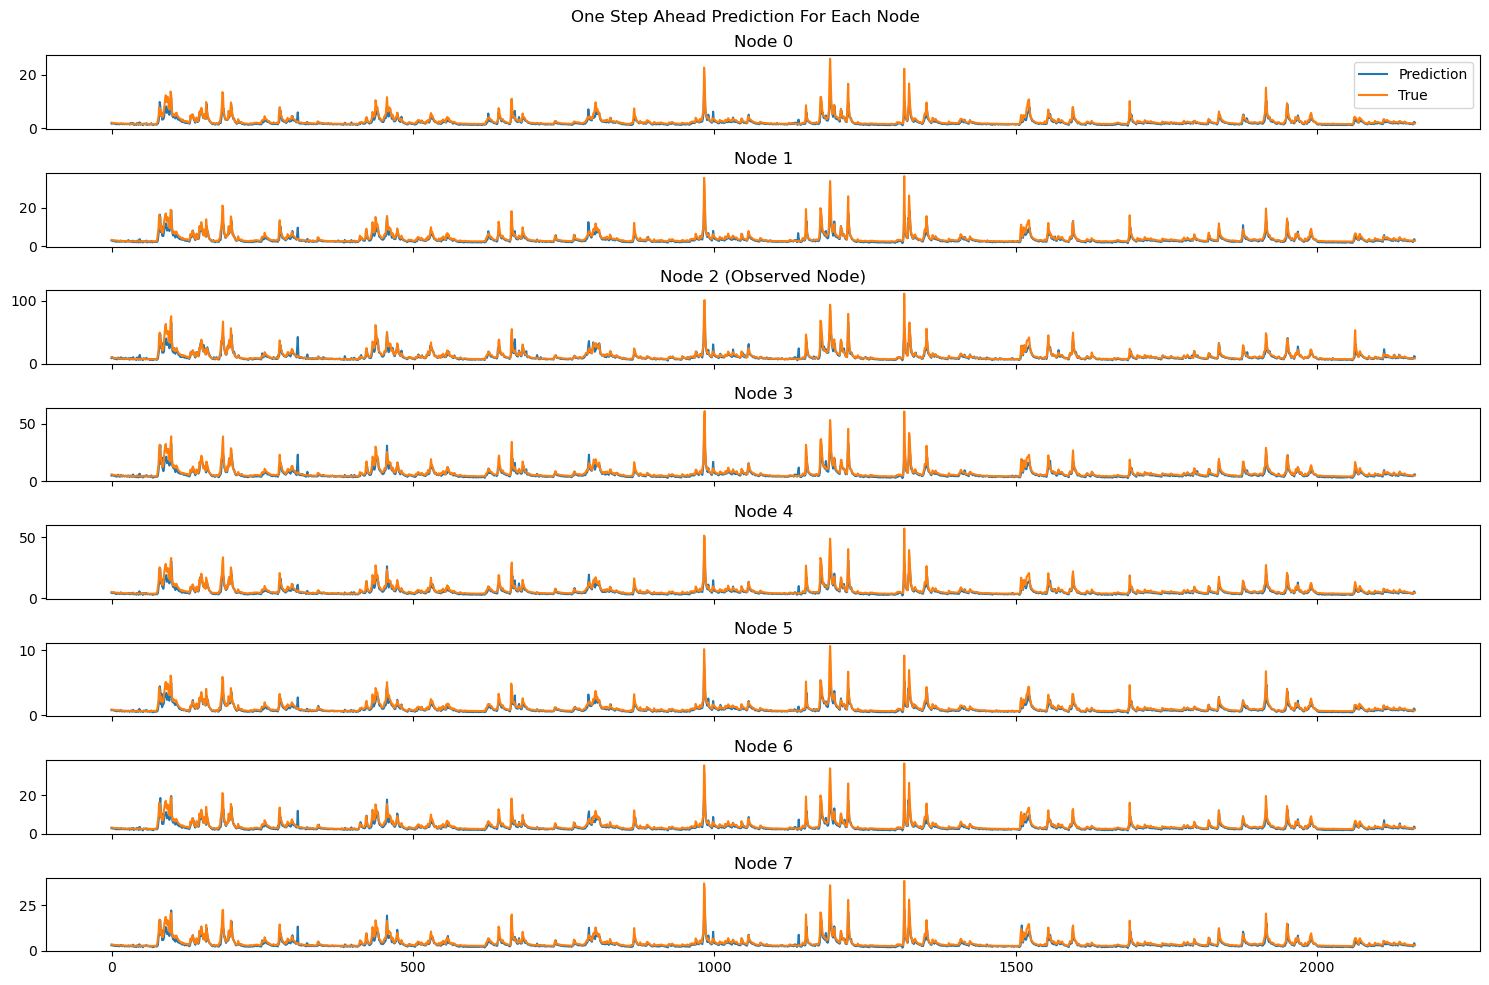

In [15]:
pt_y_pred = pt_results["01052500"]["y_pred"]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(pt_y_pred[:, 0,i], label="Prediction")
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("One Step Ahead Prediction For Each Node")
plt.tight_layout()

In [ ]:
# and also finetuning the model for the specific catchment
# we can reduce the number of epochs to 5 (fine-tuning is usually faster than training from scratch)
e.config['train']['epochs'] = 5
e.train_full(ev=True)

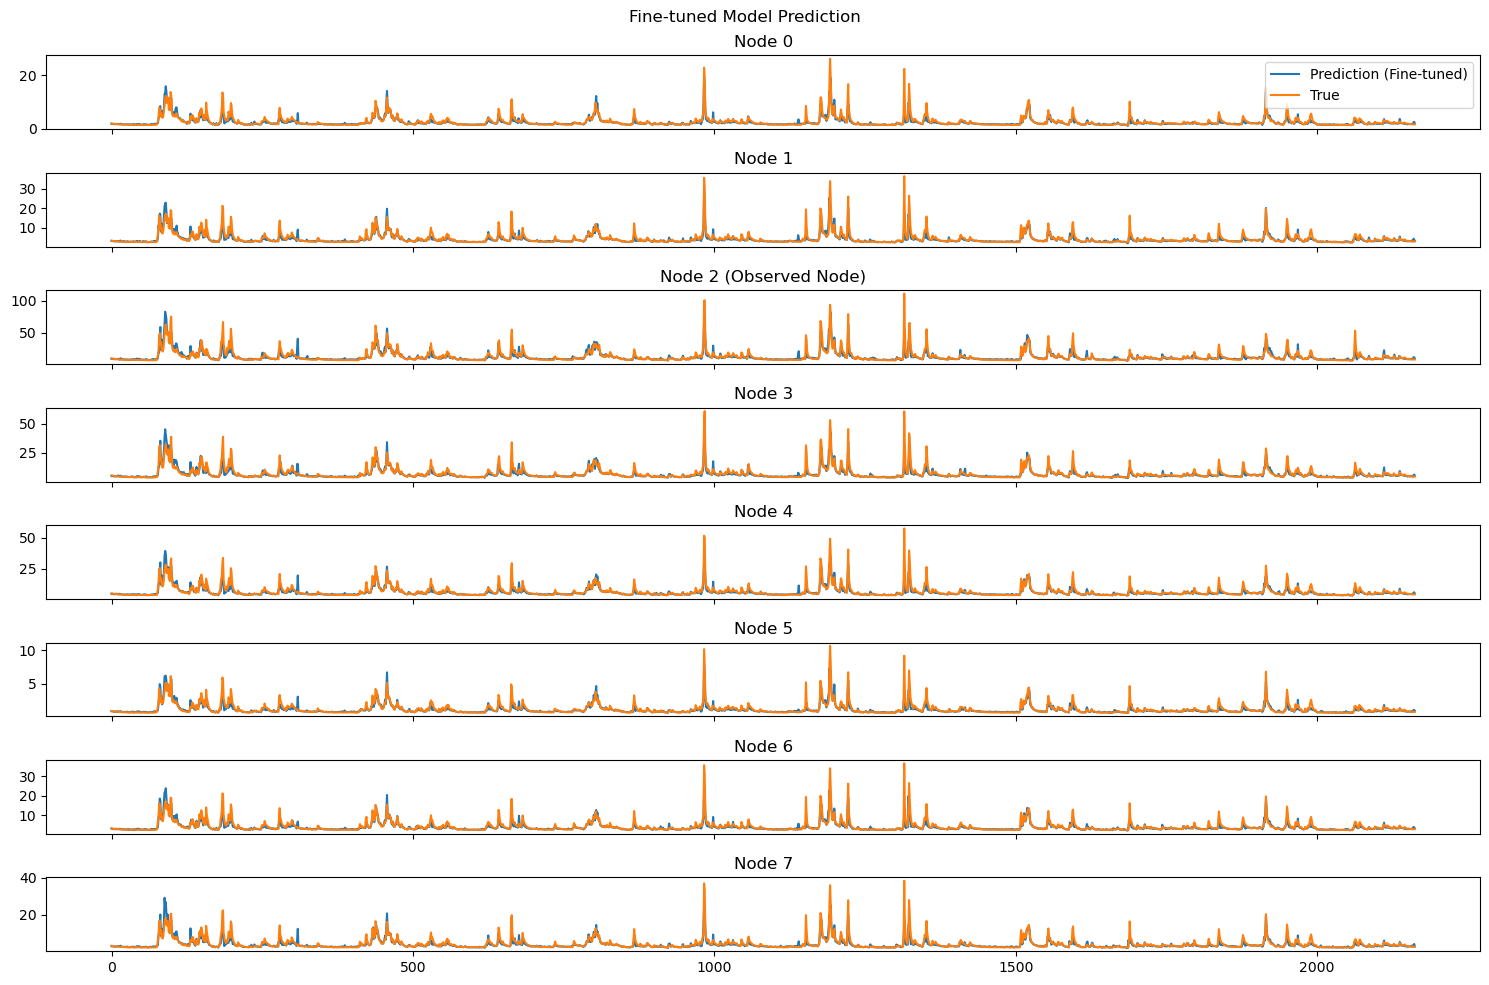

In [ ]:
_, ft_results = e.evaluate() 
ft_y_pred = ft_results["01052500"]["y_pred"]


fig, ax = plt.subplots(num_nodes, 1, figsize=(15, 10), sharex=True)
for i in range(num_nodes):
    ax[i].plot(ft_y_pred[:, 0,i], label="Prediction (Fine-tuned)")
    ax[i].plot(y_true[:, 0, i], label="True")
    ax[i].set_title(f"Node {i}")
    
    if i == 0:
        ax[i].legend()
    if i == obs_idx:
        ax[i].set_title(f"Node {i} (Observed Node)")

fig.suptitle("Fine-tuned Model Prediction")
plt.tight_layout()

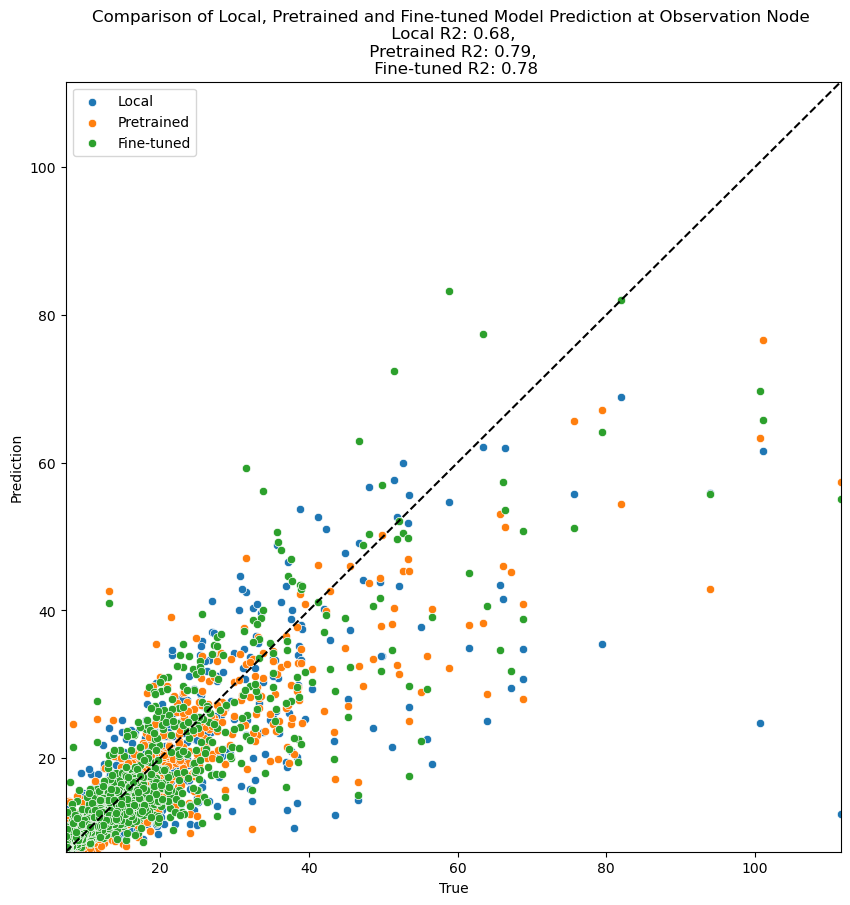

In [29]:
# Lastly, we can compare the results of the locally trained model, pretrained model and the fine-tuned model at Observation Node
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score

df = pd.DataFrame({"Local": y_pred[:, 0, obs_idx], "Pretrained": pt_y_pred[:, 0, obs_idx], "Fine-tuned": ft_y_pred[:, 0, obs_idx], "True": y_true[:, 0, obs_idx]})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df, x="True", y="Local", label="Local", ax=ax)
sns.scatterplot(data=df, x="True", y="Pretrained", label="Pretrained", ax=ax)
sns.scatterplot(data=df, x="True", y="Fine-tuned", label="Fine-tuned", ax=ax)

ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.legend()
ax.set_xlim(df["True"].min(), df["True"].max())
ax.set_ylim(df["True"].min(), df["True"].max())
ax.plot([df["True"].min(), df["True"].max()], [df["True"].min(), df["True"].max()], ls="--", c="black")
r2_local = r2_score(df["True"], df["Local"])
r2_pretrained = r2_score(df["True"], df["Pretrained"])
r2_finetuned = r2_score(df["True"], df["Fine-tuned"])
ax.set_title("Comparison of Local, Pretrained and Fine-tuned Model Prediction at Observation Node \n Local R2: {:.2f}, \n Pretrained R2: {:.2f}, \n Fine-tuned R2: {:.2f}".format(r2_local, r2_pretrained, r2_finetuned))
plt.show()
